In [1]:
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
import torchvision 
import albumentations as A
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from PIL import Image
import cv2
import os

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.is_available()

True

In [3]:
# DATA_DIR = '../input/birds50'
DATA_DIR = 'tests/00_test_img_input/train'

INPUT_SIZE = 284 # mean 284, median 170
BATCH_SIZE = 32
NUM_CLASSES = 50

MyTransform = A.Compose(
    [
    A.Rotate(limit=45, p = 0.75),
    A.RandomBrightnessContrast(p=0.5),
    A.OneOf([
        A.HueSaturationValue(40, 0, 0, p = 0.5),
        A.ToGray(p = 0.1)
    ]),
     A.GaussNoise(var_limit=(1e-5, 1e-3), p=0.5),
     A.GaussianBlur(p = 0.5)
    ]
)

def identify_transform(image):
    return { 'image' : np.copy(image) }

expand_transforms = [
    identify_transform,
    A.Rotate(limit = 45, always_apply = True),
    A.HueSaturationValue(40, 0, 0, always_apply = True),
    A.ToGray(always_apply = True),
    A.RandomBrightnessContrast(always_apply = True)
]

# Glance at data

In [4]:
labels_df = pd.read_csv('tests/00_test_img_input/train/gt.csv')

labels = []
images = []
for i, file in enumerate(os.listdir('tests/00_test_img_input/train/images')[:100]):
    img = Image.open(os.path.join(DATA_DIR, 'images', file)).convert('RGB')
    images.append(np.array(img).astype(np.uint8))
    labels.append(labels_df.iloc[i]['class_id'])

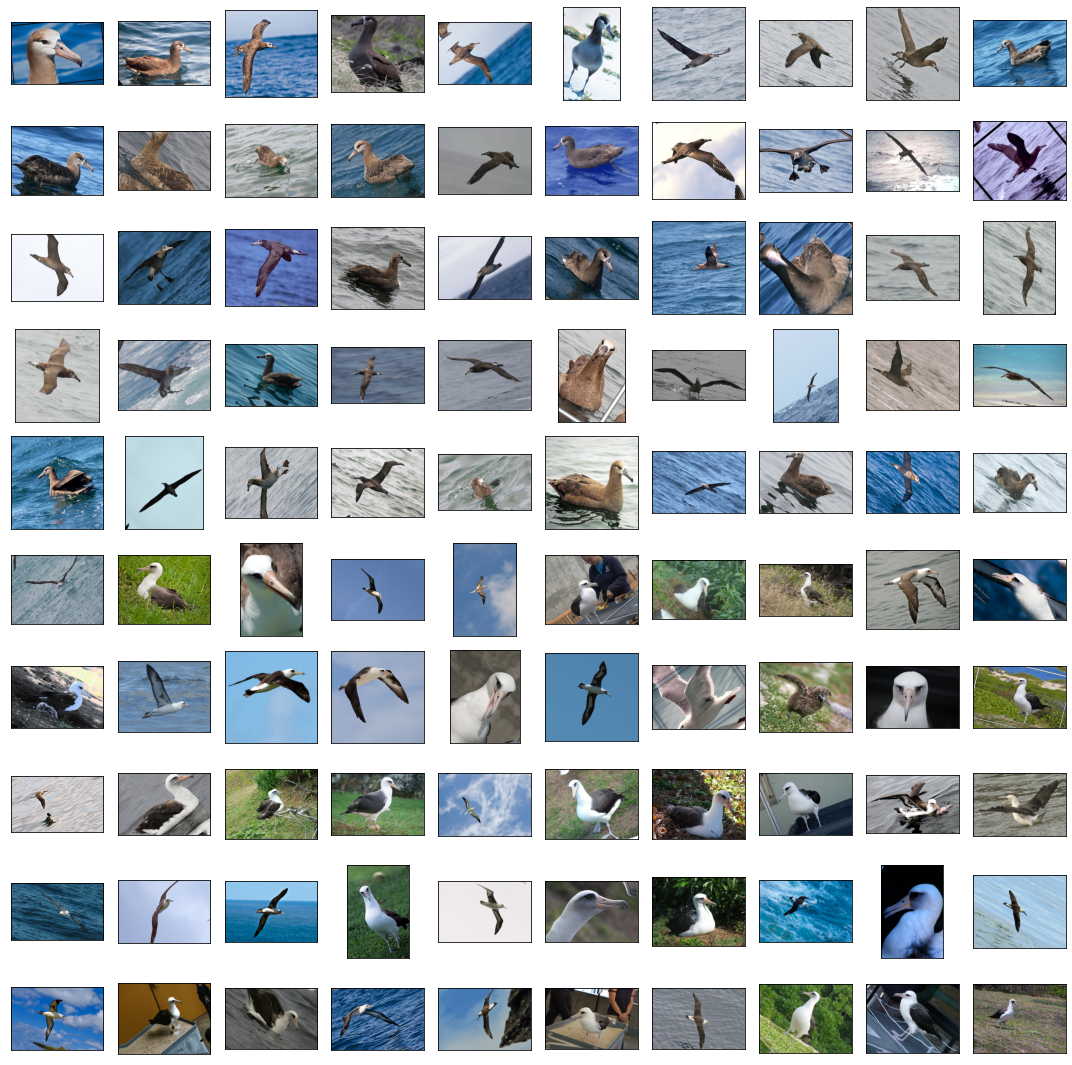

In [5]:

fig = plt.figure(figsize = (15,15))

for i in range(len(images)):
    ax = fig.add_subplot(10 , 10 , i + 1 , xticks = [] , yticks = [])
    transformed = expand_transforms[1](image = images[i])['image']
    ax.imshow(transformed , cmap = 'gray')
#     ax.set_title(labels[i])
fig.tight_layout()

# Dataset

In [6]:
def normalize(image):
    x = np.copy(image).astype(np.float32)
    for c in range(3):
        x[:, :, c] -= np.mean(x[:, :, c])
        if np.std(x[:,:,c]) != 0:
            x[:, :, c] /= np.std(x[:, :, c]) 
        else:
            print('Zero std encountered', )
    return x

def load_resize(img_path):
    image = Image.open(img_path).convert('RGB')
    image = np.array(image).astype(np.uint8)
    image = cv2.resize(image, (INPUT_SIZE, INPUT_SIZE))
    return image

def img2tensor(img):
    return torch.from_numpy(img.transpose(2, 0, 1))

class MyCustomDataset(Dataset):
    def __init__(self, 
                 mode, 
                 data_dir : str, 
                 test_size: float = 0.2, 
                 transforms = [identify_transform],
                 store_in_ram = True,
                 labels = None,
                 random_state = 42
                ):
        
        self._items = []         
        self._transforms = transforms
        self._ram = store_in_ram
        
        images_dir = os.listdir(data_dir)
        labels_raw = list(labels.values())
        X_train, X_test = train_test_split(images_dir, test_size = test_size, random_state = random_state, shuffle = True, stratify = labels_raw)
        
        if mode == 'train':
            img_names = X_train
        elif mode == 'val':
            img_names = X_test

        for img_name in img_names:
            image_path = os.path.join(data_dir, img_name)
            label = labels[img_name]      
            
            # Dataset expanding
            if store_in_ram:
                src_image = load_resize(image_path)
                images = []
                
                for transform in transforms:
                    transformed = transform(image = src_image)['image']
                    transformed = normalize(transformed)
                    transformed = img2tensor(transformed)
                    images.append(transformed)
            
                for img in images:
                    self._items.append((
                        img,
                        label
                    ))
            else:
                for i in range(len(transforms)):
                    img_transform = i
                    self._items.append((
                        image_path,
                        img_transform,
                        label
                    ))
                
        np.random.shuffle(self._items)

    def __len__(self):
        return len(self._items)

    def __getitem__(self, index):
        if self._ram:
            return self._items.__getitem__(index)
        else:
            img_path, img_transform, label = self._items.__getitem__(index)
            image = load_resize(img_path)
            image = self._transforms[img_transform](image = image)['image']
            image = normalize(image)
            image = img2tensor(image)
            
            return image, label

In [7]:
def read_csv(filename):
    res = {}
    with open(filename) as fhandle:
        next(fhandle)
        for line in fhandle:
            filename, class_id = line.rstrip('\n').split(',')
            res[filename] = int(class_id)
    return res

labels = read_csv(os.path.join(DATA_DIR, 'gt.csv'))
images_dir = os.path.join(DATA_DIR, 'images')

In [8]:
## Init train and val datasets
ds_train = MyCustomDataset(mode = "train", data_dir = images_dir, transforms = expand_transforms, store_in_ram = False, labels = labels)
ds_val = MyCustomDataset(mode = "val", data_dir = images_dir, store_in_ram = True, labels = labels)

## Init train and val dataloaders
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Callbacks

In [9]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

## Save the model periodically by monitoring a quantity.
MyModelCheckpoint = ModelCheckpoint(dirpath='runs/BirdsClassifier',
                                    filename='{epoch}-{val_loss:.3f}',
                                    monitor='val_loss', 
                                    mode='min', 
                                    save_top_k=1)

## Monitor a metric and stop training when it stops improving.
MyEarlyStopping = EarlyStopping(monitor = "val_loss",
                                mode = "min",
                                patience = 20,
                                verbose = True)

c:\program files\python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:446: UserWarning: Checkpoint directory runs/BirdsClassifier exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


# Fine-tuned model

In [10]:
def mobilenet_v2_fe(trainable_params, fast_train):
    model = torchvision.models.mobilenet_v2(pretrained = not fast_train)
    feature_extractor = model.features

    for param in list(feature_extractor.parameters())[:-trainable_params]:
        param.requires_grad = False
    
    return feature_extractor, model.last_channel

class BirdsClassifier(pl.LightningModule):
    # REQUIRED
    def __init__(self, lr = 3e-4, fast_train = False):
        super().__init__()
        self.feature_extractor, last_channel = mobilenet_v2_fe(trainable_params = 3, fast_train = fast_train)
        
        self.global_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channel, NUM_CLASSES),
            nn.Softmax(dim = 1)
        )
        
        self.loss = nn.CrossEntropyLoss()
        
        self.lr = lr
        
    # REQUIRED
    def forward(self, x):
        """ Use for inference only (separate from training_step). """
        x = self.feature_extractor(x)
        
        x = self.global_pooling(x)
        x = self.flatten(x)
        
        x = self.classifier(x)
        return x
    
    # REQUIRED
    def training_step(self, batch, batch_idx):
        """the full training loop"""
        self.training = True
        
        x, y = batch
        
        y_pred = self(x)
        
        loss = self.loss(y_pred, y)
        
        eps = 5
        acc = torch.sum(y_pred.detach().argmax(dim = 1) == y) / y.shape[0]
        
        return {'loss': loss, 'acc': acc}
    
    # REQUIRED
    def configure_optimizers(self):
        """ Define optimizers and LR schedulers. """
        optimizer = torch.optim.Adam(self.parameters(), lr = self.lr, weight_decay = 5e-4)
        
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                                  mode='min', 
                                                                  factor=0.5, 
                                                                  patience=10, 
                                                                  verbose=True)
        lr_dict = {
            # REQUIRED: The scheduler instance
            "scheduler": lr_scheduler,
            # The unit of the scheduler's step size, could also be 'step'.
            # 'epoch' updates the scheduler on epoch end whereas 'step'
            # updates it after a optimizer update.
            "interval": "epoch",
            # How many epochs/steps should pass between calls to
            # `scheduler.step()`. 1 corresponds to updating the learning
            # rate after every epoch/step.
            "frequency": 1,
            # Metric to to monitor for schedulers like `ReduceLROnPlateau`
            "monitor": "val_loss"
        } 
        
        return [optimizer], [lr_dict]
    
    # OPTIONAL
    def validation_step(self, batch, batch_idx):
        """the full validation loop"""
        self.training = False
        x, y = batch
        y_pred = self(x)
        
        loss = self.loss(y_pred, y)
    
        acc = torch.sum(y_pred.argmax(dim = 1) == y) / y.shape[0]
        
        return {'val_loss': loss, 'val_acc': acc}

    # OPTIONAL
    def training_epoch_end(self, outputs):
        """log and display average train loss and accuracy across epoch"""
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['acc'] for x in outputs]).mean()
        
        print(f"| Train_acc: {avg_acc:.2f}, Train_loss: {avg_loss:.2f}" )
        
        self.log('train_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('train_acc', avg_acc, prog_bar=True, on_epoch=True, on_step=False)
     
    # OPTIONAL
    def validation_epoch_end(self, outputs):
        """log and display average val loss and accuracy"""
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        
        print(f"[Epoch {self.trainer.current_epoch:3}] Val_acc: {avg_acc:.2f}, Val_loss: {avg_loss:.2f}", end= " ")
        
        self.log('val_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('val_acc', avg_acc, prog_bar=True, on_epoch=True, on_step=False)

# Train

In [11]:
LEARNING_RATE = 3e-4

model = BirdsClassifier(LEARNING_RATE).to(device)
# summary(model, (3, INPUT_SIZE, INPUT_SIZE))

In [12]:
trainer = pl.Trainer(
    max_epochs=1,
    gpus=1,
    callbacks=[MyEarlyStopping, MyModelCheckpoint],
    log_every_n_steps=5 # dataset is quite small
)
trainer.fit(model, dl_train, dl_val)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type              | Params
--------------------------------------------------------
0 | feature_extractor | Sequential        | 2.2 M 
1 | global_pooling    | AdaptiveAvgPool2d | 0     
2 | flatten           | Flatten           | 0     
3 | classifier        | Sequential        | 64.0 K
4 | loss              | CrossEntropyLoss  | 0     
--------------------------------------------------------
476 K     Trainable params
1.8 M     Non-trainable params
2.3 M     Total params
9.152     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

c:\program files\python39\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[Epoch   0] Val_acc: 0.05, Val_loss: 3.91 

c:\program files\python39\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 3.614


[Epoch   0] Val_acc: 0.37, Val_loss: 3.61 | Train_acc: 0.24, Train_loss: 3.75
